# CUDF

In [ ]:
import torch
GPU = torch.cuda.is_available()
if GPU:
  !nvidia-smi
else:
  print("use CPU")

use CPU


In [ ]:
if GPU:
  # This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
  # Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
  !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
  !python rapidsai-csp-utils/colab/env-check.py
  # This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
  !bash rapidsai-csp-utils/colab/update_gcc.sh
  import os
  os._exit(00)

In [ ]:
import torch
GPU = torch.cuda.is_available()
if GPU:
  # This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
  import condacolab
  condacolab.install()

# drive & kaggle

In [ ]:
list_model_type = [
    # ["lgb", "clicksxcarts", 1],
    # ["lgb", "cartsxorders", 1],
    # ["lgb", "ordersxclicks", 1],
    ["lgb", "clicksxcartsxorders", 1]

]
# modelname = "lgb"
# modelname = "lgbranker"
# modelname = "xgb"
# modelname = "xgbranker"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import json
f = open("/content/drive/MyDrive/kaggle/kaggle.json", 'r')
json_data = json.load(f) 
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']

In [ ]:
for modelname, types, w in list_model_type:
  !kaggle kernels output iwatatakuya/otto-train-$types-$modelname -p /content


Output file downloaded to /content/lgb_models_clicksxcartsxorders.pkl
Kernel log downloaded to /content/otto-train-clicksxcartsxorders-lgb.log 


In [ ]:
import torch
GPU = torch.cuda.is_available()
if GPU:
  # Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
  # The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
  !python rapidsai-csp-utils/colab/install_rapids.py stable
  import os
  os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
  os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
  os.environ['CONDA_PREFIX'] = '/usr/local'
  import cudf
  from cuml import ForestInference
  from contextlib import redirect_stdout


# メイン処理

In [ ]:
import datetime
time_notebook_start = datetime.datetime.now()+datetime.timedelta(hours=9)
print(f"notebook started {time_notebook_start}")

notebook started 2023-01-31 08:03:27.454783


In [ ]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import glob
import time
import matplotlib.pyplot as plt


from sklearn.model_selection import GroupKFold
import lightgbm as lgb

import gc

In [ ]:
n_pred = 20 # sessionごとに予測するaidの数（固定）
weight = {"clicks": 0.1, "carts": 0.3, "orders": 0.6}

types_nb = "orders"

path_input_feat = f"/content/drive/MyDrive/kaggle/otto/feature_label_valid_{{}}_{{}}.pickle"
path_input_label = {}
path_input_model = {}
for types in ["clicks", "carts", "orders"]:
  path_input_label[types] = f"/content/drive/MyDrive/kaggle/otto/n_ground_truth_valid_{types}.csv.gz"
for modelname, types_model, w in list_model_type:
  path_input_model[modelname+types_model] = f"/content/{modelname}_models_{types_model}.pkl"


n_session = {"train1": 2237925, "valid": 1735763}
sample_size = 2000000

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [ ]:
def calc_score(df_score):
    # 予測値をsessionごとに降順ソートして、上位20件のみ取得する
    df_score = df_score.sort_values(["session","pred"],ascending = False)

    for types in ["clicks", "carts", "orders"]:
      df_eval = df_score.groupby("session").head(n_pred)
      df_eval = df_eval.groupby("session")[f"label_{types}"].sum().reset_index()
      df_label = {}
      # ground truth個数データを読み込み
      df_label = pd.read_csv(path_input_label[types])
      # ground truthが20を超えている場合は20にする
      df_label[f"n_ground_truth_{types}"] = df_label["n_ground_truth"].where(df_label["n_ground_truth"] < 20, 20)
      df_eval = pd.merge(df_eval, df_label[["session", f"n_ground_truth_{types}"]], how = "left", on = "session")
     # スコアを計算
      score = df_eval[f"label_{types}"].sum() / df_eval[f"n_ground_truth_{types}"].sum()
      print(f"{types}: {score}")


In [ ]:
list_files = glob.glob(path_input_feat.format('feat','*'))

start new eval


  0%|          | 0/178 [00:00<?, ?it/s]

clicks: 0.4552123806091694
carts: 0.37649085679690575
orders: 0.6308547875298505


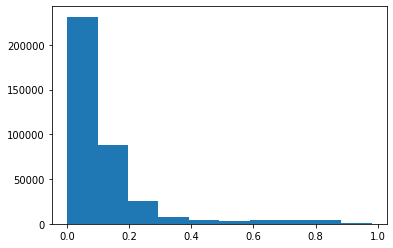

In [ ]:
if os.path.exists(f"/content/drive/MyDrive/kaggle/otto/save_eval_chunk_{types_nb}.pkl"):
  df_score = pd.read_pickle(f"/content/drive/MyDrive/kaggle/otto/save_eval_chunk_{types_nb}.pkl")
  print(f"use existing eval (n_chunk:{df_score['n_chunk']})")
else:
  print("start new eval")
  df_score = {}
  df_score["n_chunk"] = 0
  df_score["score"] = []
# for n_chunk in tqdm(range(48)):
for n_chunk in tqdm(range(len(list_files))):

  if n_chunk < df_score["n_chunk"]: continue
  feat = pd.read_pickle(path_input_feat.format("feat", n_chunk))
  label_clicks = pd.read_pickle(path_input_feat.format("clicks", n_chunk))
  label_carts = pd.read_pickle(path_input_feat.format("carts", n_chunk))
  label_orders = pd.read_pickle(path_input_feat.format("orders", n_chunk))

  df_Xy = pd.concat([feat, label_clicks, label_carts, label_orders], axis = 1)
  df_Xy = reduce_mem_usage(df_Xy, verbose = False)
  df_X = df_Xy.drop(["session", "label_clicks", "label_carts", "label_orders"], axis = 1)
  pred = np.zeros(len(df_Xy))
  # validデータに対して予測を実施
  for modelname, types_model, w in list_model_type:
    # モデル読み込み
    list_model = pd.read_pickle(path_input_model[modelname+types_model])
    if GPU:
      for model in list_model:
        model.save_model("/content/lgbm.model")
        with redirect_stdout(open(os.devnull, 'w')):
          if modelname in ["lgb", "lgbranker"]:
            fm = ForestInference.load(filename="/content/lgbm.model",output_class=True,model_type='lightgbm')
          elif modelname in ["xgb", "xgbranker"]:
            fm = ForestInference.load(filename="/content/lgbm.model",output_class=True,model_type='xgboost')
          else:
            print("modelname error")
          if modelname in ["lgb", "xgb"]:
            pred += w*fm.predict_proba(df_X)[:,1] / len(list_model)   
          elif modelname in ["lgbranker", "xgbranker"]:
            pred += w*fm.predict(df_X) / len(list_model)  
    else:
      for model in list_model:
          pred += model.predict(df_X) / len(list_model)
  if n_chunk == 0:
    plt.hist(pred)
  df_Xy_pred =  df_Xy[["session", "label_clicks", "label_carts", "label_orders"]].copy()
  df_Xy_pred["pred"] = pred
  # sessionごとの上位20件のみ保持する
  df_Xy_pred = df_Xy_pred.sort_values(["session","pred"],ascending = False)
  df_Xy_pred = df_Xy_pred.groupby("session").head(n_pred)
  df_score["score"].append(df_Xy_pred)
  df_score["n_chunk"] += 1
  # chunkの進行状況を保存
  pd.to_pickle(df_score, f"/content/drive/MyDrive/kaggle/otto/save_eval_chunk_{types_nb}.pkl")
df_score["score"] = pd.concat(df_score["score"])
calc_score(df_score["score"])

In [ ]:
import os
os.remove(f"/content/drive/MyDrive/kaggle/otto/save_eval_chunk_{types_nb}.pkl")

In [ ]:
time_notebook_end = datetime.datetime.now()+datetime.timedelta(hours=9)
time_notebook_elapsed = time_notebook_end - time_notebook_start
print(f"notebook started {time_notebook_start}")
print(f"notebook ended {time_notebook_end}")
print(f"elapsed {time_notebook_elapsed}")


notebook started 2023-01-31 08:03:27.454783
notebook ended 2023-01-31 09:55:54.756178
elapsed 1:52:27.301395


In [ ]:
import requests

notebook_name = "otto - evaluate - orders"
message = f"{notebook_name}のコミットが完了しました。"

line_token = 'xxxxxxxxxxxx'
endpoint = 'https://notify-api.line.me/api/notify'
message = "\n{}".format(message)
payload = {'message': message}
headers = {'Authorization': 'Bearer {}'.format(line_token)}
requests.post(endpoint, data=payload, headers=headers)

<Response [200]>

In [ ]:
import time
time.sleep(60)
from google.colab import runtime
runtime.unassign()